In [1]:
USER = 'ruvim'

# Load dataset, import convenience functions

In [2]:
from _rate_movies_helper import dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
ratings = dataset.load('ratings.csv').drop('timestamp', axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Figure out which movies mostly likely have been seen

In order to minimize the amount of the user spends manually rating movies we will only ask about frequently reviewed movies (that are therefore likely to have been seen by the user).

In [4]:
def get_movieId_vs_n_ratings_and_avg_rating(ratings_df):
    ratings_df = ratings_df.copy()
    ratings_df['n_ratings'] = 1
    ratings_df['avg_rating'] = ratings_df['rating']
    return ratings_df[['n_ratings', 'movieId']].groupby('movieId').count().merge(
        ratings_df[['avg_rating', 'movieId']].groupby('movieId').mean(), on='movieId')

In [5]:
def restrict_ratings(ratings, low, high):
    '''Return `ratings` with just ratings in [low, high)'''
    return ratings[(ratings['avg_rating'] < high) & (ratings['avg_rating'] >= low)]

In [6]:
def get_most_rated(ratings_df, at_least_n_ratings=50, top_n=200, avg_rating_range=(0, 5.1)):
    df = get_movieId_vs_n_ratings_and_avg_rating(ratings_df)
    df = restrict_ratings(df, *avg_rating_range)
    df = df[df['n_ratings'] >= at_least_n_ratings]
    return df.sort_values('n_ratings', ascending=False).iloc[:top_n]

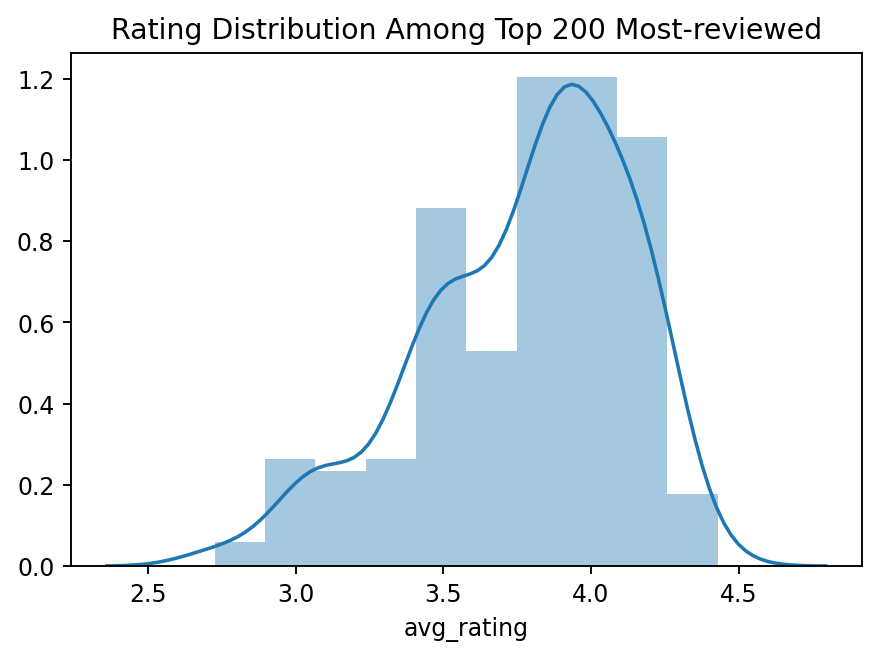

In [7]:
top200_most_rated = get_most_rated(ratings, top_n=200)
plt.figure(dpi=170)
ax = sns.distplot(top200_most_rated['avg_rating'])
title = ax.set_title('Rating Distribution Among Top 200 Most-reviewed')

# Just going off of popularity, most movies have a good rating

To combat this and to make sure our user is shown at least a few "bad" movies that they didn't like, we will lower the threshold for certain ratings.

In [8]:
rated0to1 = get_most_rated(ratings, at_least_n_ratings=5, avg_rating_range=(0, 1))
rated1to2 = get_most_rated(ratings, at_least_n_ratings=10, avg_rating_range=(1, 2))
rated2to3 = get_most_rated(ratings, at_least_n_ratings=35, avg_rating_range=(2, 3), top_n=48)
rated3to4 = get_most_rated(ratings, at_least_n_ratings=100, avg_rating_range=(3, 4))
rated4to4_5 = get_most_rated(ratings, at_least_n_ratings=70, avg_rating_range=(4, 4.5))
rated4_5to5 = get_most_rated(ratings, at_least_n_ratings=50, avg_rating_range=(4.5, 5.1))

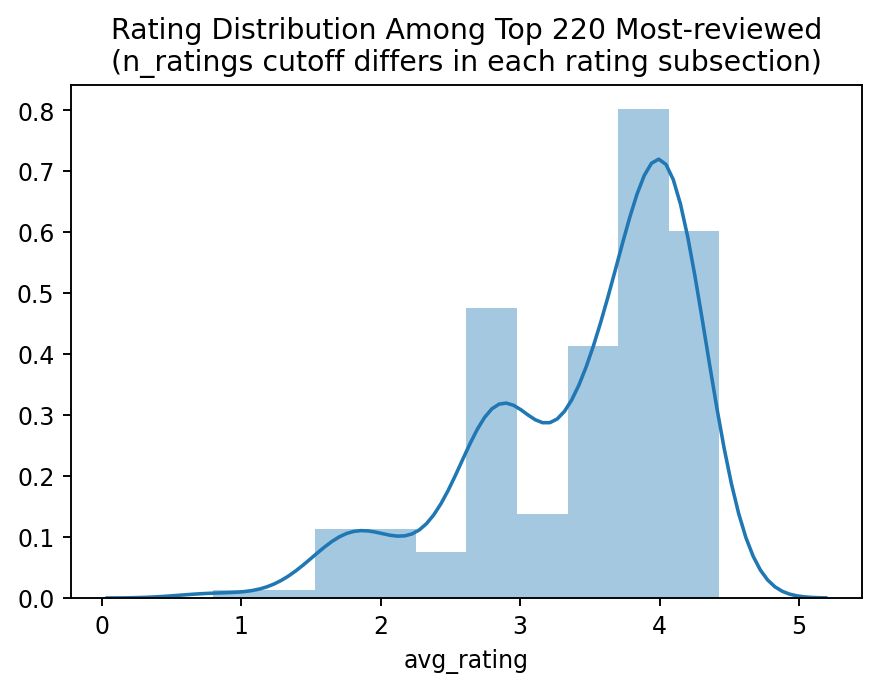

In [9]:
better = pd.concat([rated0to1, rated1to2, rated2to3, rated3to4, rated4to4_5, rated4_5to5])

plt.figure(dpi=170)
ax = sns.distplot(better['avg_rating'])
title = ax.set_title(f'Rating Distribution Among Top {len(better.index)} Most-reviewed\n'
                    '(n_ratings cutoff differs in each rating subsection)')

# Time to manually rate the movies

I've implemented an easy-to-use interface by modifying the [pigeon](https://github.com/agermanidis/pigeon) package. Rating movies is self-explanatory, preferences are saved automatically to `./preferences/[your username]_pref.csv`. If you want to reset your progress, just delete that preference file, a black one will be created when you run the next cells.

In [10]:
from _rate_movies_helper import annotate, display_movie, load_preferences

In [11]:
try:
    already_rated = load_preferences(USER)
except FileNotFoundError:
    reduced = better.index
else:
    reduced = [movieId for movieId in better.index if movieId not in already_rated['movieId'].values]

In [12]:
annot = annotate(reduced, display_fn=display_movie, include_skip=False,
             options=['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5', '?'], user=USER)

HTML(value='0 examples annotated, 221 examples left')

Output()

Annotation done.
